# Ambient Temperature System Failure Analysis

In [1]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import os
from google.colab import drive

In [9]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Anomaly_Detection_Time_Series/')
#file_path = 'ambient_temperature_system_failure.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Loading and Preprocessing

In [10]:
# Function to load and preprocess data
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)

    # Exclude timestamp column and convert to float
    data_values = data.drop('timestamp', axis=1).values.astype('float32')

    # Create a new DataFrame
    data_converted = pd.DataFrame(data_values, columns=data.columns[1:])
    data_converted.insert(0, 'timestamp', data['timestamp'])

    # Drop missing values
    data_converted = data_converted.dropna()

    return data_converted

In [11]:
# Function to build the autoencoder model
def build_autoencoder(input_dim, encoding_dim=10):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='relu')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [12]:
def calculate_anomaly_scores(autoencoder, data_tensor, threshold_quantile=0.99):
    reconstructions = autoencoder.predict(data_tensor)
    mse = tf.reduce_mean(tf.square(data_tensor - reconstructions), axis=1)
    anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')

    threshold = anomaly_scores.quantile(threshold_quantile)
    anomalous = anomaly_scores > threshold
    return anomaly_scores, anomalous

In [13]:
def plot_anomalies(data_converted, anomaly_scores, anomalous):
    plt.figure(figsize=(16, 8))
    plt.plot(data_converted['timestamp'], data_converted['value'], label="Values")
    plt.plot(data_converted['timestamp'][anomalous], data_converted['value'][anomalous], 'ro', label="Anomalies")
    plt.title('Anomaly Detection')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [16]:
# Load and preprocess data
data_converted = load_and_preprocess_data('ambient_temperature_system_failure.csv')

# Convert data to tensor for TensorFlow
data_tensor = tf.convert_to_tensor(data_converted.drop('timestamp', axis=1).values, dtype=tf.float32)


### 1.1 Summary Statistics and Initial Analysis

First few rows of the dataset:
             timestamp      value
0  2013-07-04 00:00:00  69.880836
1  2013-07-04 01:00:00  71.220230
2  2013-07-04 02:00:00  70.877808
3  2013-07-04 03:00:00  68.959396
4  2013-07-04 04:00:00  69.283554

Basic Statistics:
             value
count  7267.000000
mean     71.242432
std       4.247510
min      57.458405
25%      68.369408
50%      71.858490
75%      74.430958
max      86.223213

Missing Data:
timestamp    0
value        0
dtype: int64

Median of the 'value' column: 71.85848999023438

Mean of the 'value' column: 71.242431640625

Unique Values Count:
timestamp    7267
value        7256
dtype: int64


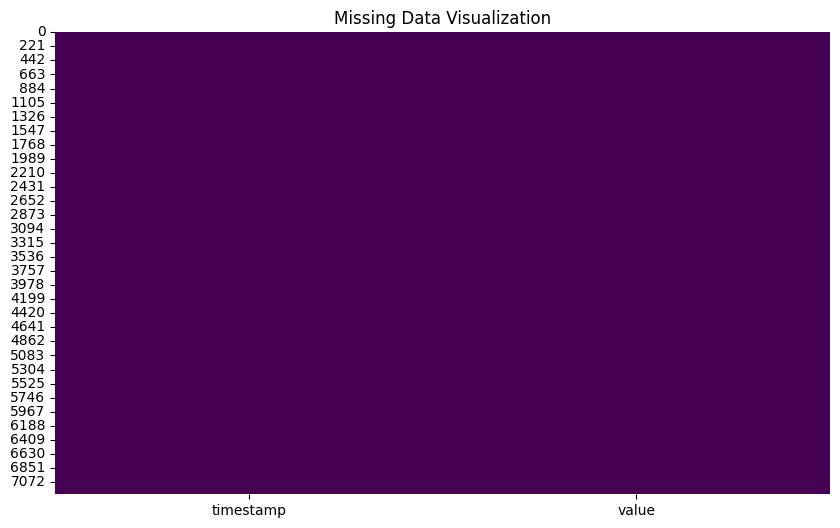


Correlation Matrix (without 'timestamp'):
       value
value    1.0


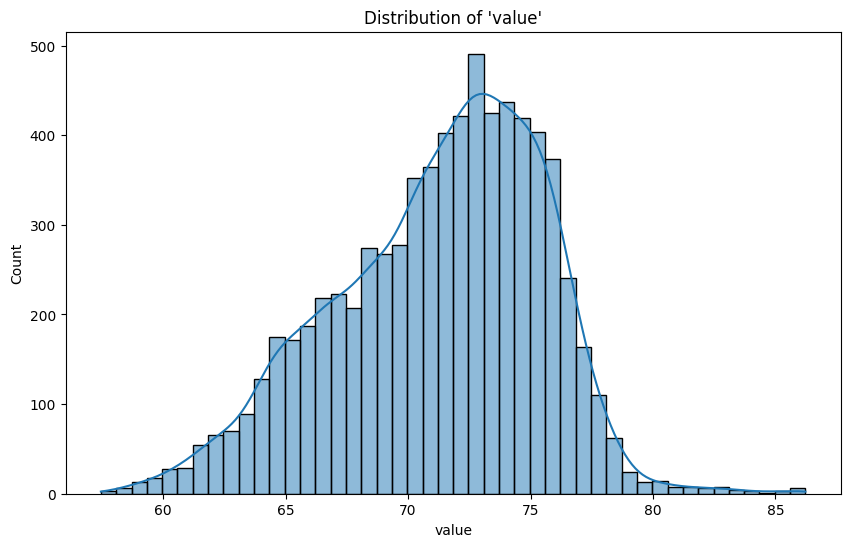

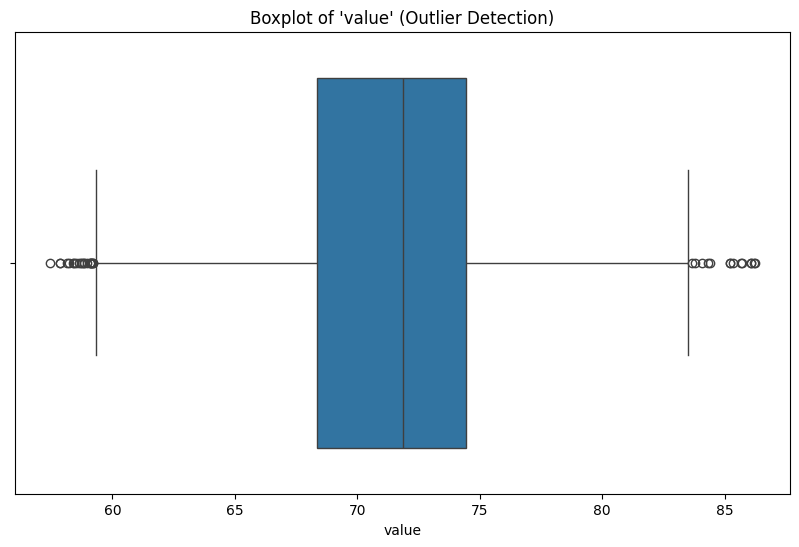

In [28]:
# # Loading data
# data = pd.read_csv('/mnt/data/ambient_temperature_system_failure.csv')

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data_converted.head())

# Basic statistics: mean, median, standard deviation, etc.
print("\nBasic Statistics:")
print(data_converted.describe())

# Check for missing data
print("\nMissing Data:")
print(data_converted.isnull().sum())

# Median of the values column (assuming you want median for the 'value' column)
if 'value' in data_converted.columns:
    print(f"\nMedian of the 'value' column: {data_converted['value'].median()}")

# Mean of the values column
if 'value' in data_converted.columns:
    print(f"\nMean of the 'value' column: {data_converted['value'].mean()}")

# Checking for unique values in each column
print("\nUnique Values Count:")
print(data_converted.nunique())

# Visualizing missing data (if any)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(data_converted.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Visualization")
plt.show()

# Checking for correlation between numeric columns
print("\nCorrelation Matrix (without 'timestamp'):")
numeric_data = data_converted.drop(columns=['timestamp'])  # Drop non-numeric 'timestamp' column
print(numeric_data.corr())

# Visualizing the distribution of the 'value' column (assuming it's a numerical column)
plt.figure(figsize=(10,6))
sns.histplot(data_converted['value'], kde=True)
plt.title("Distribution of 'value'")
plt.show()

# Checking for outliers using boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x=data_converted['value'])
plt.title("Boxplot of 'value' (Outlier Detection)")
plt.show()


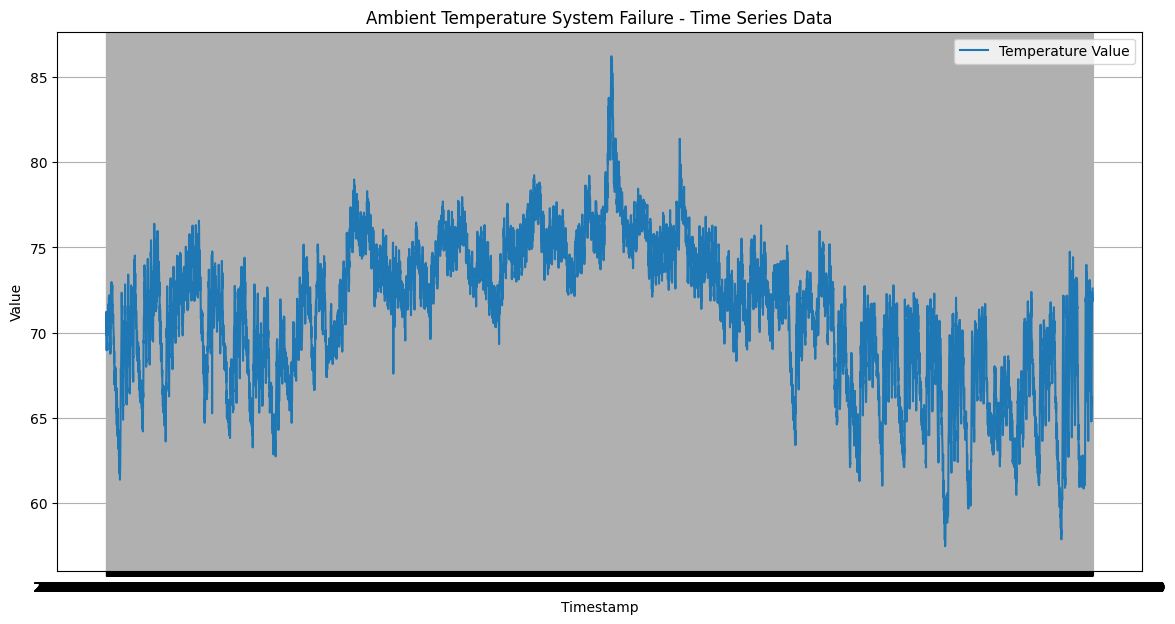

In [22]:
# Plot the time series data
plt.figure(figsize=(14, 7))
plt.plot(data_converted['timestamp'], data_converted['value'], label="Temperature Value")
plt.title("Ambient Temperature System Failure - Time Series Data")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

In [17]:
input_dim = data_converted.shape[1] - 1
autoencoder = build_autoencoder(input_dim)
history = autoencoder.fit(data_tensor, data_tensor, epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5087.8066
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5088.5957
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5096.5435
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5084.2349
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5089.4165
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5080.5308
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5096.2773
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5090.3350
Epoch 9/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5084.3926
Epoch 10/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5093.4487
Epoch 11/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5081.4756
Epoch 12/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5091.9106
Epoch 13/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5099.4849
Epoch 14/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5090.3633
Epoch 15/50
228

In [18]:
anomaly_scores, anomalous = calculate_anomaly_scores(autoencoder, data_tensor)

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [19]:
binary_labels = anomalous.astype(int)
precision, recall, f1_score, _ = precision_recall_fscore_support(binary_labels, anomalous, average='binary')
roc_auc = roc_auc_score(binary_labels, anomaly_scores)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

Precision: 1.00
Recall: 1.00
F1 Score: 1.00
ROC-AUC Score: 1.00


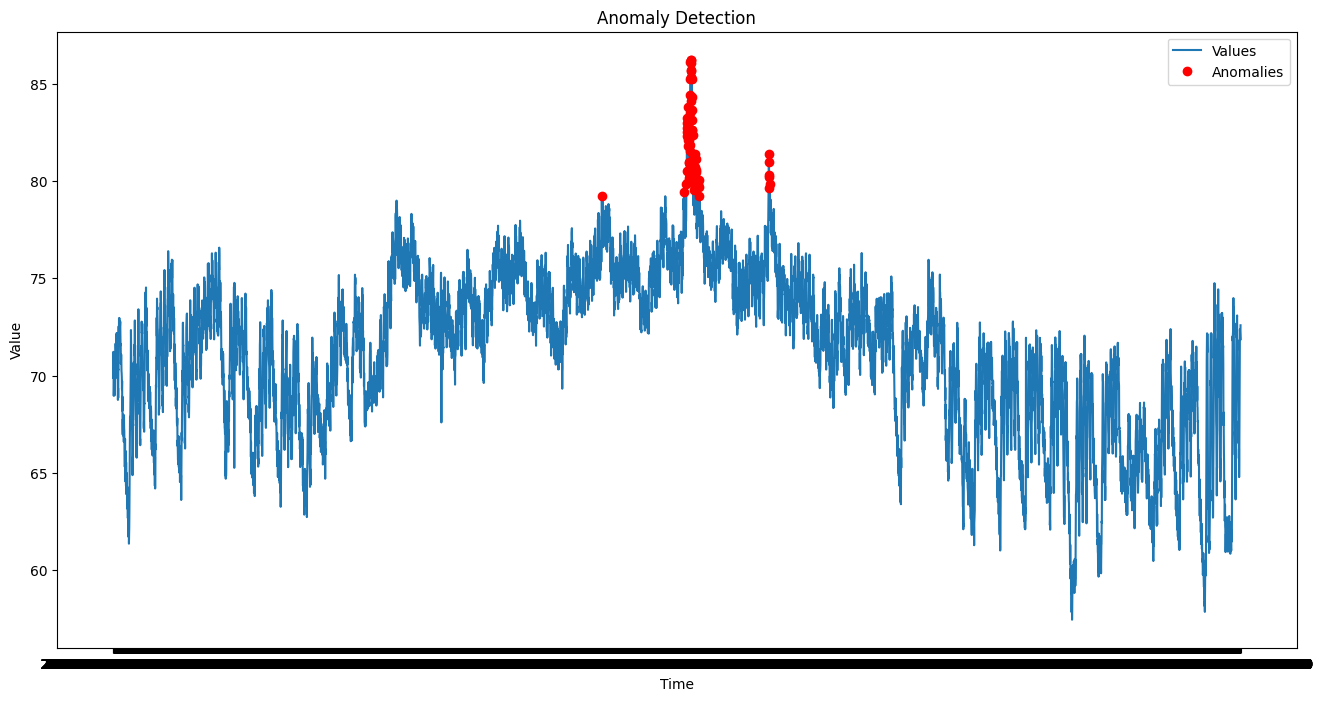

In [20]:

plot_anomalies(data_converted, anomaly_scores, anomalous)

1. Seasonal Decomposition:

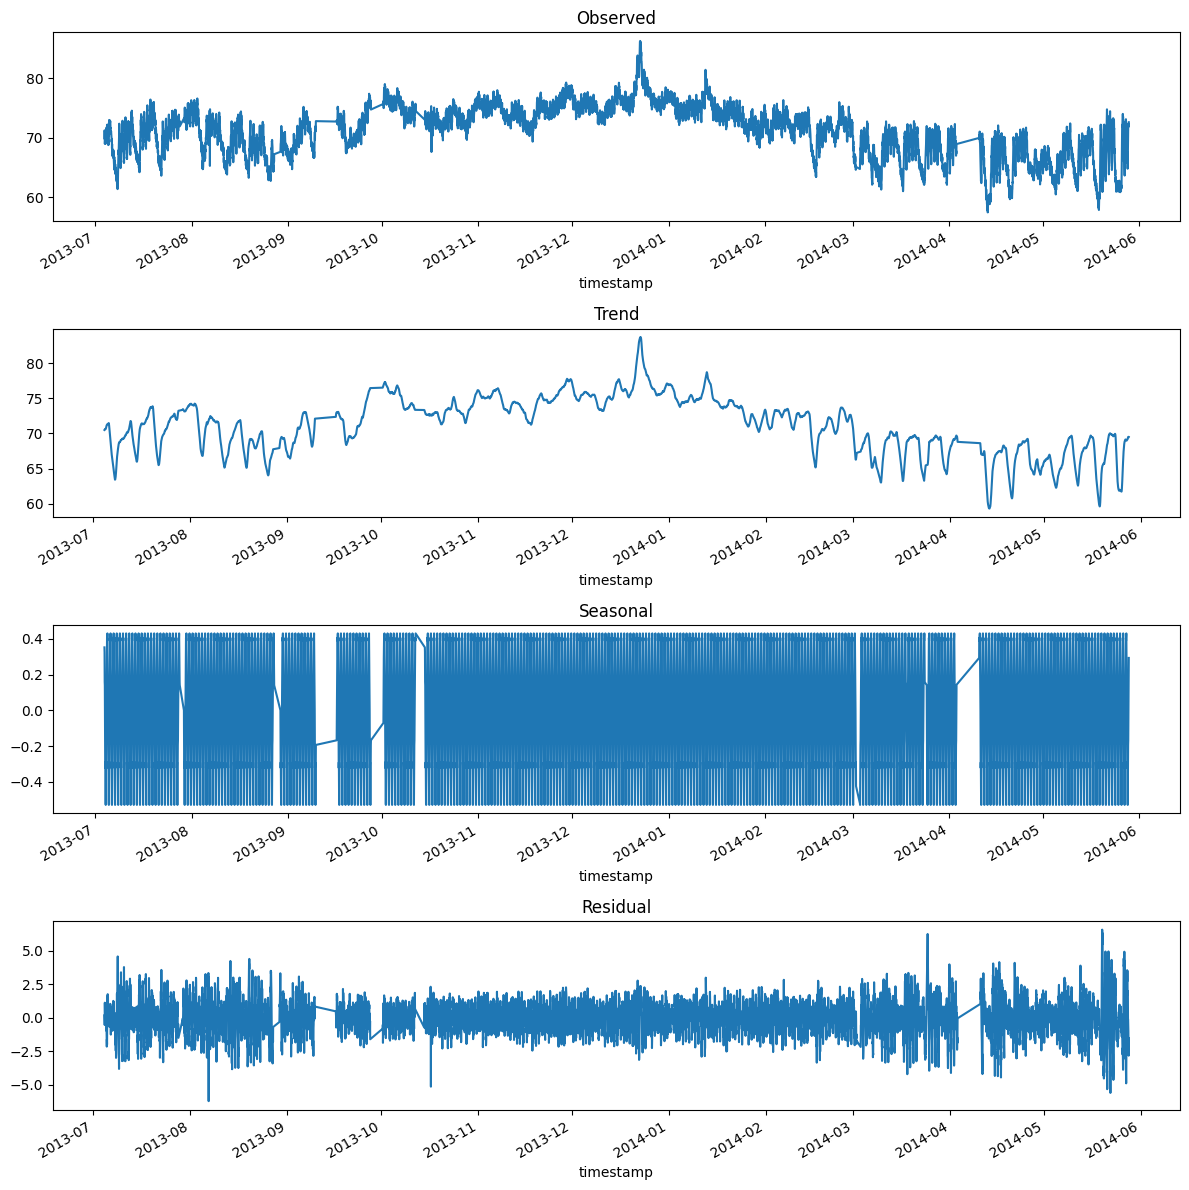

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Convert timestamp column to datetime
data_converted['timestamp'] = pd.to_datetime(data_converted['timestamp'])

# Set timestamp as the index
data_converted.set_index('timestamp', inplace=True)

# Perform seasonal decomposition
decomposition = seasonal_decompose(data_converted['value'], model='additive', period=24)  # Assuming 24-hour periodicity

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()


2. Rolling Statistics:

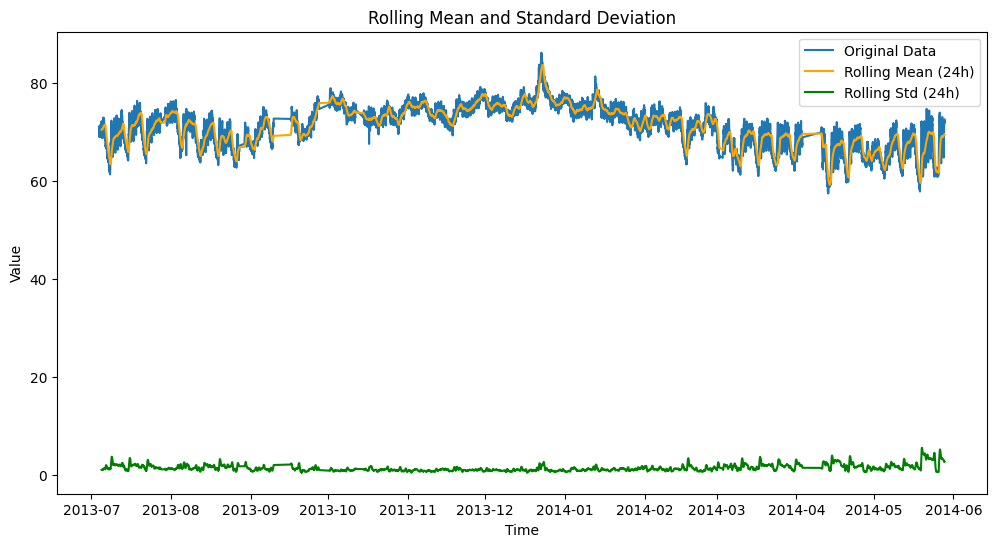

In [30]:
# Calculate rolling statistics
rolling_mean = data_converted['value'].rolling(window=24).mean()
rolling_std = data_converted['value'].rolling(window=24).std()

# Plot rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(data_converted['value'], label='Original Data')
plt.plot(rolling_mean, color='orange', label='Rolling Mean (24h)')
plt.plot(rolling_std, color='green', label='Rolling Std (24h)')
plt.title('Rolling Mean and Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [32]:
!pip install statsmodels ruptures

3.Autocorrelation, Partial Autocorrelation, and Change Point

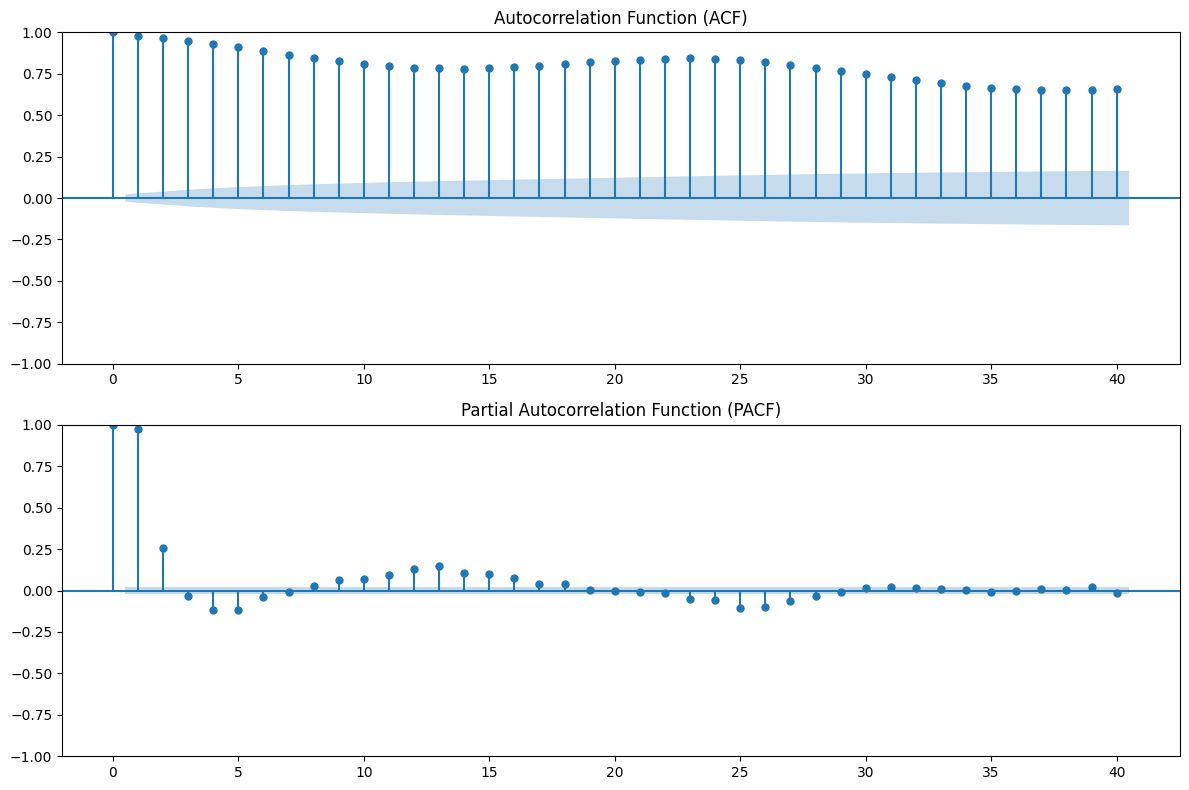

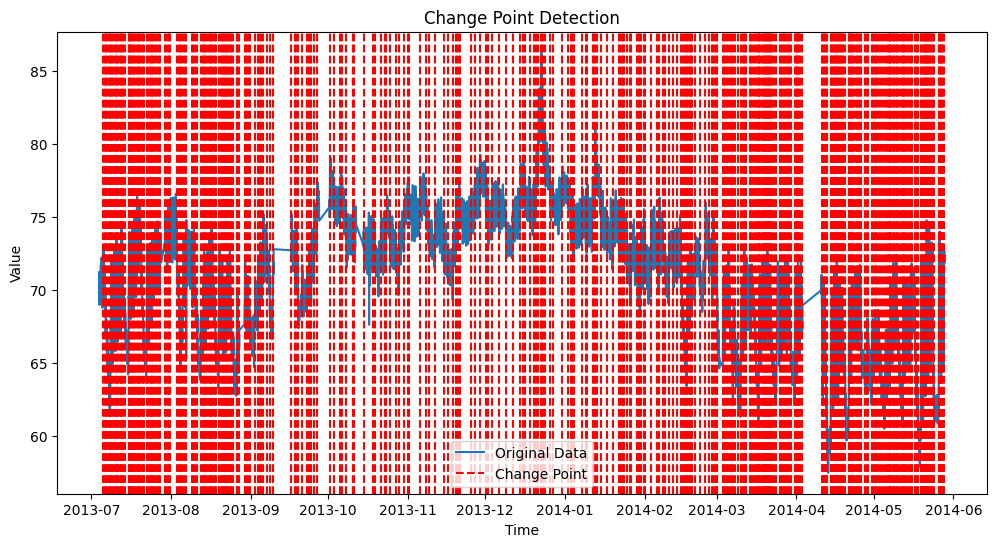

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ruptures as rpt

# Load the data
data = pd.read_csv('ambient_temperature_system_failure.csv')

# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set timestamp as the index
data.set_index('timestamp', inplace=True)

# Autocorrelation and Partial Autocorrelation plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelation (ACF) plot
sm.graphics.tsa.plot_acf(data['value'], lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Partial Autocorrelation (PACF) plot
sm.graphics.tsa.plot_pacf(data['value'], lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Change Point Detection using 'ruptures'
# We use the Pelt algorithm with an L2 cost model
model = "l2"  # Least squares estimation
algo = rpt.Pelt(model=model).fit(data['value'].values)

# Predict change points
result = algo.predict(pen=10)

# Ensure the detected change points are within the bounds of the data index
plt.figure(figsize=(12, 6))
plt.plot(data['value'], label='Original Data')

for cp in result:
    if cp < len(data):
        plt.axvline(x=data.index[cp], color='red', linestyle='--', label='Change Point' if cp == result[0] else "")

plt.title('Change Point Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


4.Outlier Robustness:

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


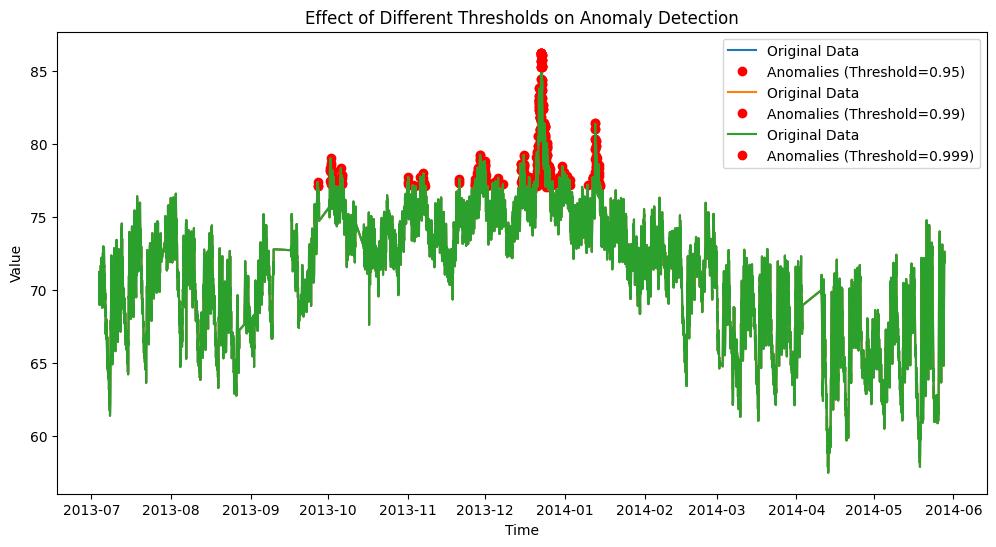

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to detect anomalies with different thresholds
def detect_anomalies(data_tensor, autoencoder, data_converted, thresholds=[0.95, 0.99, 0.999]):
    # Get reconstructions from the autoencoder
    reconstructions = autoencoder.predict(data_tensor)

    # Calculate Mean Squared Error (MSE) between actual data and reconstructed data
    mse = np.mean(np.square(data_tensor - reconstructions), axis=1)

    # Create a Series for anomaly scores with the same index as the original data
    anomaly_scores = pd.Series(mse, index=data_converted.index, name='anomaly_scores')

    # Loop over different quantile thresholds
    plt.figure(figsize=(12, 6))
    for threshold in thresholds:
        # Define the threshold for anomalies
        threshold_value = anomaly_scores.quantile(threshold)
        anomalous = anomaly_scores > threshold_value

        # Plot the original data and mark the anomalies
        plt.plot(data_converted.index, data_converted['value'], label='Original Data')
        plt.plot(data_converted.index[anomalous], data_converted['value'][anomalous], 'ro', label=f'Anomalies (Threshold={threshold})')

    plt.title('Effect of Different Thresholds on Anomaly Detection')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Example call (using your trained autoencoder and the original DataFrame)
detect_anomalies(data_tensor, autoencoder, data_converted, thresholds=[0.95, 0.99, 0.999])


5. Time Series Forecasting with ARIMA:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 7267
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -8975.772
Date:                Wed, 23 Oct 2024   AIC                          17967.544
Time:                        00:19:57   BIC                          18022.672
Sample:                             0   HQIC                         17986.504
                               - 7267                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4559      0.010    140.750      0.000       1.436       1.476
ar.L2         -0.2827      0.018    -15.483      0.000      -0.319      -0.247
ar.L3         -0.1627      0.021     -7.728      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-37-1475c39e2f89>:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(data.index[-1], periods=n_steps, freq='H'), forecast, label='Forecast', color='orange')


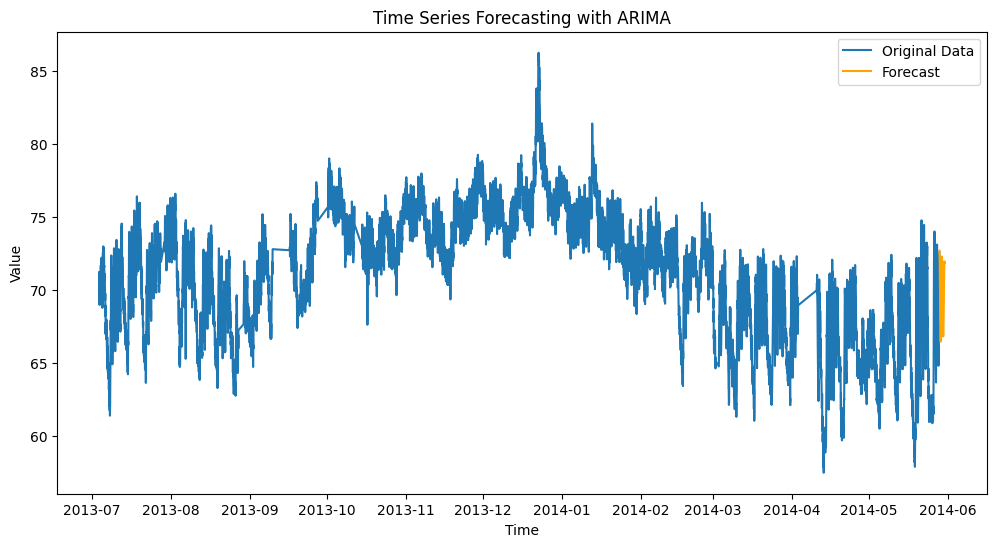

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model (p, d, q) where p, d, q are parameters chosen through experimentation
# For example: ARIMA(5,1,2) - AR terms: 5, I terms: 1 (differencing), MA terms: 2
model = ARIMA(data['value'], order=(5, 1, 2))

# Fit the model
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

# Forecast future values
n_steps = 50  # Number of future steps to predict
forecast = model_fit.forecast(steps=n_steps)

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='Original Data')
plt.plot(pd.date_range(data.index[-1], periods=n_steps, freq='H'), forecast, label='Forecast', color='orange')

plt.title('Time Series Forecasting with ARIMA')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


6. Time-Dependent Anomaly Thresholds:

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


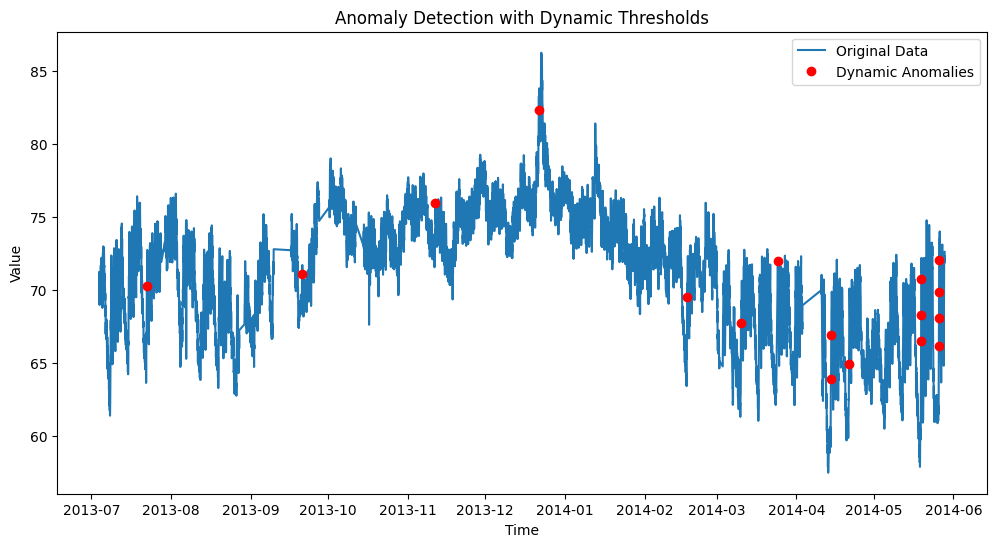

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to detect anomalies using dynamic thresholds
def detect_dynamic_threshold_anomalies(data_converted, autoencoder, window_size=24, sigma=3):
    # Get reconstructions from the autoencoder
    # data_tensor = tf.convert_to_tensor(data_converted.drop('timestamp', axis=1).values, dtype=tf.float32)
    reconstructions = autoencoder.predict(data_tensor)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean(np.square(data_tensor - reconstructions), axis=1)
    anomaly_scores = pd.Series(mse, index=data_converted.index, name='anomaly_scores')

    # Calculate rolling mean and rolling standard deviation
    rolling_mean = anomaly_scores.rolling(window=window_size).mean()
    rolling_std = anomaly_scores.rolling(window=window_size).std()

    # Define dynamic threshold as mean + n standard deviations (sigma)
    dynamic_threshold = rolling_mean + sigma * rolling_std

    # Detect anomalies where the anomaly score exceeds the dynamic threshold
    anomalies = anomaly_scores > dynamic_threshold

    # Plot the data and mark anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(data_converted.index, data_converted['value'], label='Original Data')
    plt.plot(data_converted.index[anomalies], data_converted['value'][anomalies], 'ro', label='Dynamic Anomalies')
    plt.title('Anomaly Detection with Dynamic Thresholds')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Example call to the function
detect_dynamic_threshold_anomalies(data_converted, autoencoder, window_size=24, sigma=3)


7. Advanced Visualizations /n
1.1. Correlation Heatmap

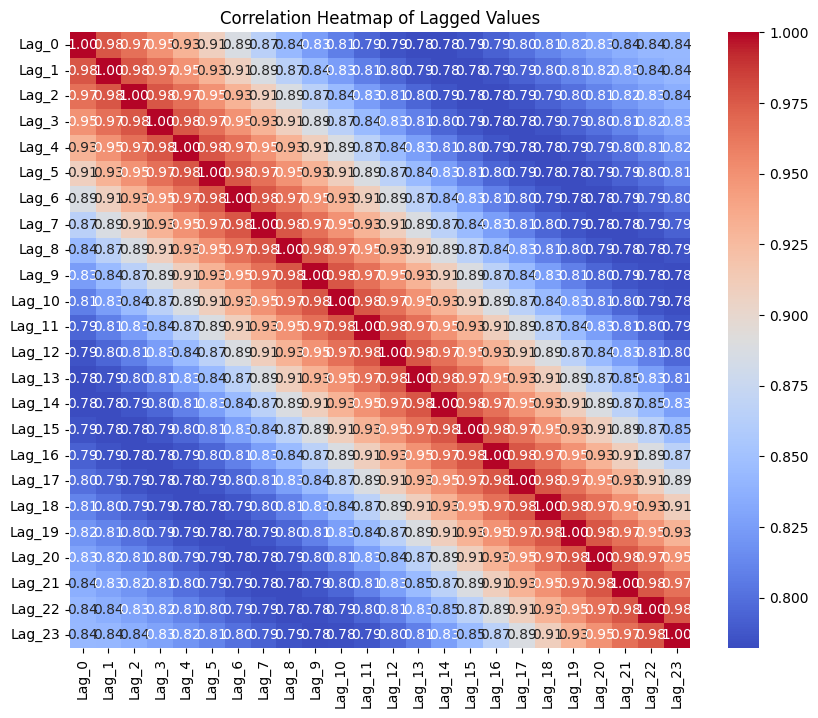

In [41]:
import seaborn as sns
import numpy as np

# Create a correlation heatmap for lagged values
def plot_correlation_heatmap(data_converted, max_lag=24):
    lagged_data = pd.concat([data_converted['value'].shift(i) for i in range(max_lag)], axis=1)
    lagged_data.columns = [f"Lag_{i}" for i in range(max_lag)]

    # Drop NaN values introduced by shifting
    lagged_data = lagged_data.dropna()

    # Compute the correlation matrix
    corr_matrix = lagged_data.corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Lagged Values')
    plt.show()

# Example call to the function
plot_correlation_heatmap(data_converted, max_lag=24)



2. Anomaly Evolution Graph

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


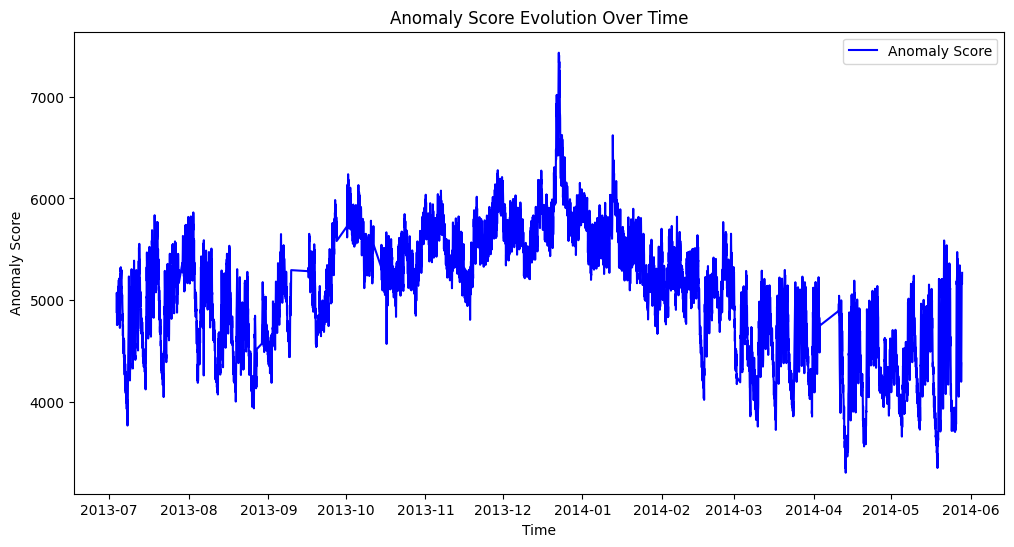

In [43]:
# Plot anomaly scores over time to observe their evolution
def plot_anomaly_evolution(data_converted, autoencoder):
    # Get reconstructions from the autoencoder
    # data_tensor = tf.convert_to_tensor(data_converted.drop('timestamp', axis=1).values, dtype=tf.float32)
    reconstructions = autoencoder.predict(data_tensor)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean(np.square(data_tensor - reconstructions), axis=1)
    anomaly_scores = pd.Series(mse, index=data_converted.index, name='anomaly_scores')

    # Plot anomaly scores over time
    plt.figure(figsize=(12, 6))
    plt.plot(anomaly_scores, label='Anomaly Score', color='blue')
    plt.title('Anomaly Score Evolution Over Time')
    plt.xlabel('Time')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.show()

# Example call to the function
plot_anomaly_evolution(data_converted, autoencoder)
